In [34]:
pip install -q pandas matplotlib scikit-learn transformers tf-keras tensorflow #==2.16.1 

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#==2.16.1': Expected package name at the start of dependency specifier
    #==2.16.1
    ^


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace 'your_file.csv' with the path to your CSV file
df = pd.read_csv('combined_dfv2.csv', dtype=str)

df = df.dropna(subset=['max_predicted_aspect', 'Combined Text'])

filtered_df = df[df['Month of Response Date'] == 'Apr-24']
filtered_df['max_predicted_aspect'] = filtered_df['max_predicted_aspect'].replace({'Product/print quality': 'Quality'})
df_prep = filtered_df

df_prep.head(3)

C:\Users\royle\AppData\Local\Temp\ipykernel_7292\3178984877.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['max_predicted_aspect'] = filtered_df['max_predicted_aspect'].replace({'Product/print quality': 'Quality'})


,Survey ID,Product Name,Print Customer Region,LTR,Source Type,Survey language,Review Source,Star Rating,Product Family,Supplies Family,...,Model Name,Combined Text,Ink Supply Type,token_count,Month of Response Date,predicted_level1,predicted_probabilities,max_predicted_probability,max_predicted_level1,max_predicted_aspect
18,110020182,HP 63 Black Original Ink Cartridge,US,10,Web Reviews,English,Walmart,5,Supplies - Ink,Dolmen Refresh,...,HP 63 Black Original Ink Cartridge,"Excllent quality; easy to order, received prom...",IPH,7,Apr-24,"Logistic Handling, General satisfied","['0.8352197918762199', '0.7786848755893012']",0.880666667,Brand Loyalty,Others
108,123460320,HP 65XL Black Original Ink Cartridge,US,10,Web Reviews,English,Walmart,5,Supplies - Ink,Dolmen Refresh,...,HP 65XL Black Original Ink Cartridge,Great price and arrived even earlier than stated.,IPH,8,Apr-24,Logistic Handling,['0.7908739113381595'],0.796588235,Brand Loyalty,Others
137,132417974,HP 65XL Black Original Ink Cartridge,US,10,Web Reviews,English,Walmart,5,Supplies - Ink,Dolmen Refresh,...,HP 65XL Black Original Ink Cartridge,Ink gets used up way to quickly for the price ...,IPH,40,Apr-24,Others,['0'],0.903254902,Brand Loyalty,Others


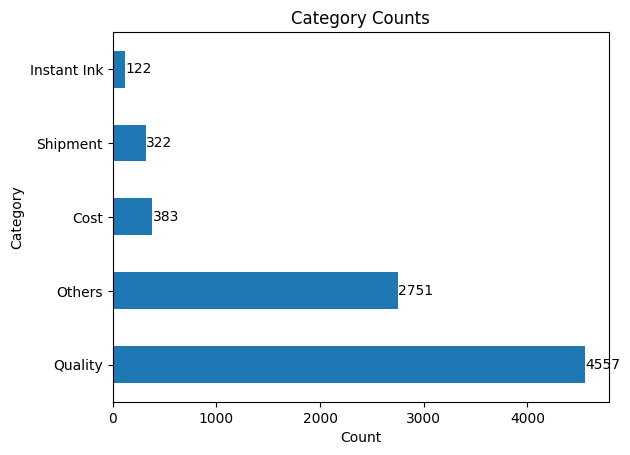

In [10]:
value_counts = filtered_df['max_predicted_aspect'].value_counts()

# Plot horizontal bar chart
ax = value_counts.plot(kind='barh')

# Add data labels on the bars
for i in ax.containers:
    ax.bar_label(i)

# Add labels and title
plt.xlabel('Count')
plt.ylabel('Category')
plt.title('Category Counts')

# Show the plot
plt.show()


In [24]:
# Combined Text
# max_predicted_aspect

df_prep['encoded_cat'] = df_prep['max_predicted_aspect'].astype('category').cat.codes

data_texts = df_prep['Combined Text'].to_list() # Features (not tokenized yet)
data_labels = df_prep['encoded_cat'].to_list() # Labels

# Get the categories and their corresponding codes
cat_mapping = dict(enumerate(df_prep['max_predicted_aspect'].astype('category').cat.categories))

cat_mapping

C:\Users\royle\AppData\Local\Temp\ipykernel_7292\3659413152.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prep['encoded_cat'] = df_prep['max_predicted_aspect'].astype('category').cat.codes


{0: 'Cost', 1: 'Instant Ink', 2: 'Others', 3: 'Quality', 4: 'Shipment'}

In [17]:
from sklearn.model_selection import train_test_split
 
# Split Train and Validation data
# train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=0, shuffle=True)

# # 100% of Data for training
train_texts = data_texts
train_labels = data_labels
val_texts = data_texts
val_labels = data_labels
 
# Keep some data for inference (testing)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.01, random_state=0, shuffle=True)

###############################################################################################################################################

from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
import tensorflow as tf
import pandas as pd


tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

# Create TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings),train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings),val_labels))

# TFTrainer Class for Fine-tuning
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5) 
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [14]:
import torch

# Check number of GPUs
num_gpus = torch.cuda.device_count()
print("Number of GPU(s):", num_gpus)

# Check GPU name
if num_gpus > 0:
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("No GPU found.")

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU(s): 1
GPU Name: NVIDIA GeForce RTX 3070 Ti
Using device: cuda


In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
 
model.fit(train_dataset.shuffle(1000).batch(16),
epochs=5,
batch_size=16,
validation_data=val_dataset.shuffle(1000).batch(16),
callbacks=[early_stopping]
)


AttributeError: 'SimpleModel' object has no attribute 'fit'

In [37]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score

# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# # 100% of Data for training
train_texts = data_texts
train_labels = data_labels
val_texts = data_texts
val_labels = data_labels

# Tokenize the training and validation texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors='pt')
val_encodings = tokenizer(val_texts, truncation=True, padding=True, return_tensors='pt')

# Create a PyTorch Dataset
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])  # Ensure labels are tensors
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

# Set device
device = torch.device("cuda" if gpu_available else "cpu")

# Load the model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)
model.to(device)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                 # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    evaluation_strategy="epoch",     # evaluate every epoch
    save_strategy="epoch",           # save model every epoch
    load_best_model_at_end=True,     # load the best model at the end
)

# Define compute_metrics function to calculate accuracy
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc
    }

# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics  # Pass the function here
)

# Train the model
trainer.train()

C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optim

  0%|          | 0/2545 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [34]:
# Save the model, tokenizer, and training arguments to the output directory
model.save_pretrained('./distilbert aspect classification')
tokenizer.save_pretrained('./distilbert aspect classification')
# training_args.save('./final_model')


('./distilbert aspect classification\\tokenizer_config.json',
 './distilbert aspect classification\\special_tokens_map.json',
 './distilbert aspect classification\\vocab.txt',
 './distilbert aspect classification\\added_tokens.json')

In [35]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

# Load the saved model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained('./distilbert aspect classification')
tokenizer = DistilBertTokenizer.from_pretrained('./distilbert aspect classification')

# (Optional) Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Single test sentence
test_sentence = "colors were vibrant"

# Tokenize the input sentence
inputs = tokenizer(test_sentence, return_tensors="pt", truncation=True, padding=True)

# Move inputs to the same device as the model
inputs = {k: v.to(model.device) for k, v in inputs.items()}

# Model inference (prediction)
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

# Get predicted label (numerical)
pred_label = torch.argmax(logits, dim=1).item()

# Map the predicted label to the original category using category_dict
predicted_category = cat_mapping[pred_label]

# Print the predicted label and the category title
print(f"Predicted label: {pred_label}")
print(f"Predicted category: {predicted_category}")

Predicted label: 3
Predicted category: Quality


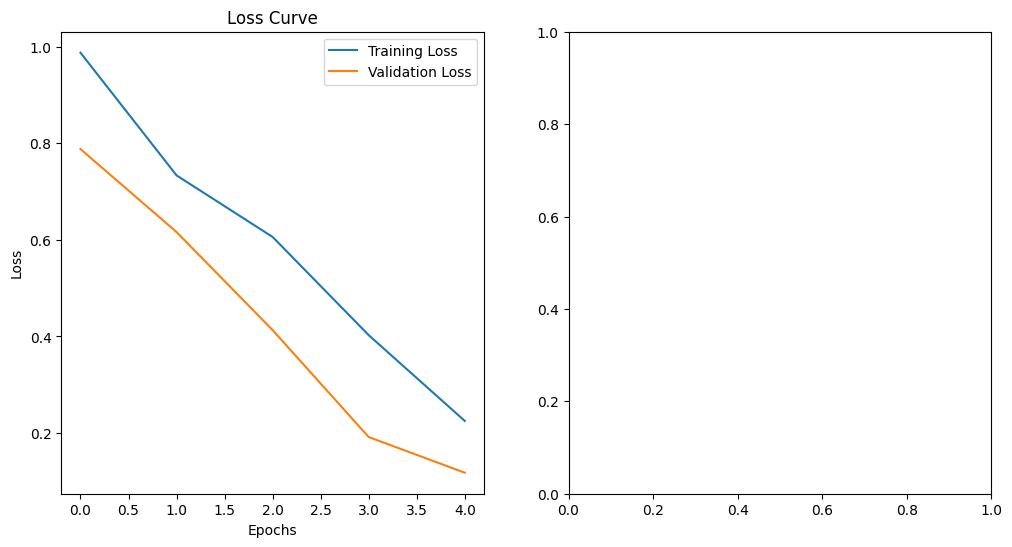

In [36]:
import matplotlib.pyplot as plt

# Extract the logs
history = trainer.state.log_history

# Extract loss and accuracy for both training and validation
train_loss = [entry['loss'] for entry in history if 'loss' in entry]
val_loss = [entry['eval_loss'] for entry in history if 'eval_loss' in entry]
train_acc = [entry['accuracy'] for entry in history if 'accuracy' in entry]
val_acc = [entry['eval_accuracy'] for entry in history if 'eval_accuracy' in entry]

# Plot loss curve
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy curve (if available)
plt.subplot(1, 2, 2)
if train_acc and val_acc:  # Check if accuracy is available
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.show()